### Functions

In [0]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Dealing with Class Imbalance 

In this notebook I will be trying various common techniques and ideas that I have in dealing with class imbalance within <b>tabular</b> datasets. I would eventually like to try to move this idea over to non-tabular as well, but that is for in the future when my skills have enhanced.

In [0]:
from fastai import *
from fastai.tabular import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)

In [0]:
df = pd.read_csv(path/'adult.csv')

First I want to look at the overall class imbalance

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [5]:
df['salary'].unique()

array(['>=50k', '<50k'], dtype=object)

In [6]:
df['salary'].value_counts()

<50k     24720
>=50k     7841
Name: salary, dtype: int64

So we have 24,720 samples for less than 50,000, and 7,841 samples for above 50,000. That is quite a difference. As a baseline, I will make the standard tabular model, with a train/validation/test split of 70/20/10 respectively

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_set, test = train_test_split(df, test_size=0.1)

Split and very it is (roughly) 90% into the training and 10% into test

In [9]:
len(train_set)+len(test), len(df)

(32561, 32561)

In [10]:
len(train_set)/len(df)

0.8999723595712662

In [0]:
del df

Rerun for the train and validation sets

In [0]:
train, valid = train_test_split(train_set, test_size=0.2)

In [12]:
len(train), len(valid)

(23443, 5861)

In [0]:
del train_set

Now in order to make the splits work whenever we are dealing with over and undersampling techniques, I need to split my train/test by an idx, as we will need to constantly keep track of where to split them from if I want to use the standard TabularDataBunch instead of seperate item lists. Given no sampling is done here, I could just use train_set, but I will show example code for how we will be doing it for the rest of the notebook.

In [0]:
train_val = train.append(valid)

In [10]:
len(train_val) == len(train) + len(valid)

True

I will be using the same variable choice as was chosen in the lesson 4 notebook.

In [0]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 
             'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In [0]:
data_train = (TabularList.from_df(train_val, path=path, cat_names=cat_names, 
                                  cont_names=cont_names, procs=procs)
             .split_by_idx(list(range(len(train), len(train_val))))
             .label_from_df(cols=dep_var)
             .databunch())

Now just to verify we split properly, the numbers in train and valid should equal that of the above totals for our dataset

In [13]:
data_train

TabularDataBunch;

Train: LabelList (23443 items)
x: TabularList
workclass  Private; education  HS-grad; marital-status  Married-civ-spouse; occupation  Farming-fishing; relationship  Husband; race  White; education-num_na False; age -0.7034; fnlwgt -1.1100; education-num -0.4245; ,workclass  Private; education  Some-college; marital-status  Married-civ-spouse; occupation  Tech-support; relationship  Husband; race  White; education-num_na False; age 0.8384; fnlwgt -0.9189; education-num -0.0328; ,workclass  Private; education  Some-college; marital-status  Married-civ-spouse; occupation  Exec-managerial; relationship  Husband; race  White; education-num_na False; age -0.7768; fnlwgt -0.5351; education-num -0.0328; ,workclass  Self-emp-not-inc; education  Bachelors; marital-status  Married-civ-spouse; occupation  Craft-repair; relationship  Husband; race  White; education-num_na False; age -0.1160; fnlwgt -1.4470; education-num 1.1420; ,workclass  Private; education  HS-grad; marital-st

Next, we make a labeled test set in order to grade the performance. **Notice** we pass in the data_train's processor to get the matching preprocessing.

In [0]:
data_test = (TabularList.from_df(test, path=path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs, 
                                processor=data_train.processor)
            .split_none()
            .label_from_df(cols=dep_var)
            .databunch())

Now we can instantiate a Learner, and fit for an epoch or three

### Average Run

In [0]:
arr = []
mc = []
for x in range(10):
  learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
  learn.fit(5, 1e-2)
  learn.data.valid_dl = data_test.train_dl
  res = learn.validate()
  arr.append(float(res[1]))
  intp = ClassificationInterpretation.from_learner(learn)
  mc.append(intp.most_confused())

In [23]:
arr

[0.8387500047683716,
 0.8362500071525574,
 0.8399999737739563,
 0.8324999809265137,
 0.8368750214576721,
 0.839062511920929,
 0.8393750190734863,
 0.8428124785423279,
 0.8340625166893005,
 0.840624988079071]

In [24]:
mc

[[('>=50k', '<50k', 385), ('<50k', '>=50k', 129)],
 [('>=50k', '<50k', 398), ('<50k', '>=50k', 123)],
 [('>=50k', '<50k', 328), ('<50k', '>=50k', 174)],
 [('>=50k', '<50k', 273), ('<50k', '>=50k', 262)],
 [('>=50k', '<50k', 322), ('<50k', '>=50k', 204)],
 [('>=50k', '<50k', 337), ('<50k', '>=50k', 181)],
 [('>=50k', '<50k', 348), ('<50k', '>=50k', 165)],
 [('>=50k', '<50k', 347), ('<50k', '>=50k', 150)],
 [('>=50k', '<50k', 406), ('<50k', '>=50k', 124)],
 [('>=50k', '<50k', 310), ('<50k', '>=50k', 199)]]

In [31]:
test['salary'].value_counts()

<50k     2507
>=50k     750
Name: salary, dtype: int64

In [27]:
len(test)

3257

### Three Epochs

In [0]:
learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)

In [22]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.366731,0.354285,0.840983,00:03
1,0.364115,0.352365,0.836205,00:03
2,0.361952,0.346569,0.835352,00:03
3,0.362227,0.345088,0.844395,00:03
4,0.365821,0.347312,0.843030,00:03


Now we swap the dataloaders and run on our test set

In [0]:
learn.data.valid_dl = data_test.train_dl

In [24]:
learn.validate()

[0.3572009, tensor(0.8359)]

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

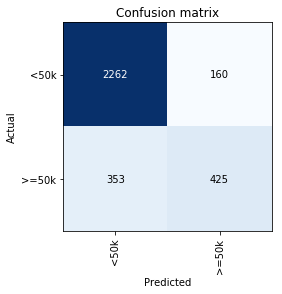

In [26]:
interp.plot_confusion_matrix()

Our baseline to beat is 83.59% accuracy at 5 epochs with a constant learning rate of 1e-2. If we look at the confusion matrix, we can see that **most** of the confused values (more than 2x the other) was from the minority class, >=50k. Now let's explore some data manipulation to help (or not help) with class imbalance. The three options I will be exploring below first will be **undersampling**, **oversampling**, and a hybrid of the two, where we dictate a mean for all classes and over- or under- sample accordingly

## Undersampling

Undersampling operates like this: we look at the class with the smallest population, and we decrease the larger classes untill they fit. I will be performing this by randomly-selecting a variety of samples from the original dataset to fill another.
One key to note here, when we do any sort of sampling, we want to ensure this is **only** done on the training dataset, not the validation nor the test dataset to ensure no data leakage, and the validation and test data still are representative of the **original** dataset

In [0]:
def underSample(df:pd.DataFrame, var:str):
  limit = int(df[var].value_counts().min())
  lst = []
  
  for class_index, group in df.groupby(var):
    if len(group) > limit:
      lst.append(group.sample(limit, replace=True))
    else:
      lst.append(group)
  df = pd.concat(lst)
  return df

In [33]:
train['salary'].value_counts()

<50k     17799
>=50k     5644
Name: salary, dtype: int64

Let's view a histogram of the numerical categories to see how their distrobution lie

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1bf89cea20>], dtype=object)

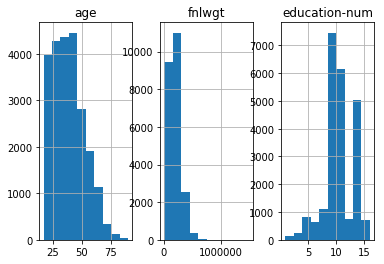

In [87]:
fig, ax = plt.subplots(1,3)

train.hist(column='age', ax=ax[0])
train.hist(column='fnlwgt', ax=ax[1])
train.hist(column='education-num', ax=ax[2])

Let's also look at the mean and standard devation so we can compare

In [0]:
def reportInfo(df:pd.DataFrame, cols):
  cols = list(cols)
  df = pd.DataFrame(columns=['Variable', 'Mean', 'Standard Deviation'])
  for x in range(len(cols)):
    df.loc[x] = [str(cols[x]), train[cols[x]].mean(), train[cols[x]].std()]
  return df

In [0]:
cols = ['age', 'fnlwgt', 'education-num']

In [31]:
reportInfo(train, cols)

,Variable,Mean,Standard Deviation
0,age,38.664847,13.626584
1,fnlwgt,189751.523440,105222.890775
2,education-num,10.088145,2.574420


In [0]:
under = underSample(train, 'salary')

In [224]:
under['salary'].value_counts()

<50k     5629
>=50k    5629
Name: salary, dtype: int64

We dropped down to 5,697 samples per class via random selection of sampling. Let's see how the distrobution changed for the classes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1bf88fa208>], dtype=object)

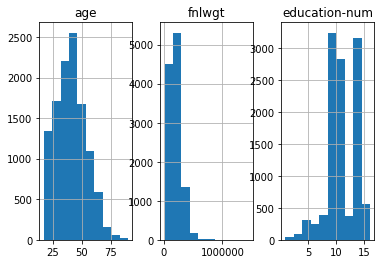

In [88]:
fig, ax = plt.subplots(1,3)

under.hist(column='age', ax=ax[0])
under.hist(column='fnlwgt', ax=ax[1])
under.hist(column='education-num', ax=ax[2])

Now let's view the Mean and Standard Deviation side by side. You will notice there was not that much of a difference here, we were able to keep the distrobution ok, but don't forget we did lose 1/3 of the data for one class! That's a lot of values

In [123]:
display_side_by_side(reportInfo(under, cols), reportInfo(train, cols))

,Variable,Mean,Standard Deviation
0,age,38.563025,13.599243
1,fnlwgt,189808.817344,105728.323595
2,education-num,10.085744,2.576080
,Variable,Mean,Standard Deviation
0,age,38.563025,13.599243
1,fnlwgt,189808.817344,105728.323595
2,education-num,10.085744,2.576080


In [132]:
len(under), len(valid)

(11394, 5861)

In [0]:
train_val = under.append(valid)

In [34]:
len(train_val)

17237

Let's try training

In [0]:
data_train = (TabularList.from_df(train_val, path=path, cat_names=cat_names, 
                                  cont_names=cont_names, procs=procs)
             .split_by_idx(list(range(len(under), len(train_val))))
             .label_from_df(cols=dep_var)
             .databunch())


data_test = (TabularList.from_df(test, path=path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs, 
                                processor=data_train.processor)
            .split_none()
            .label_from_df(cols=dep_var)
            .databunch())



### 10 Times

In [0]:
arr = []
mc = []
for x in range(10):
  learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
  learn.fit(5, 1e-2)
  learn.data.valid_dl = data_test.train_dl
  res = learn.validate()
  arr.append(float(res[1]))
  intp = ClassificationInterpretation.from_learner(learn)
  mc.append(intp.most_confused())

In [39]:
mc

[[('<50k', '>=50k', 687), ('>=50k', '<50k', 88)],
 [('<50k', '>=50k', 334), ('>=50k', '<50k', 234)],
 [('<50k', '>=50k', 755), ('>=50k', '<50k', 74)],
 [('<50k', '>=50k', 512), ('>=50k', '<50k', 139)],
 [('<50k', '>=50k', 394), ('>=50k', '<50k', 219)],
 [('<50k', '>=50k', 465), ('>=50k', '<50k', 158)],
 [('<50k', '>=50k', 575), ('>=50k', '<50k', 126)],
 [('<50k', '>=50k', 445), ('>=50k', '<50k', 171)],
 [('<50k', '>=50k', 684), ('>=50k', '<50k', 93)],
 [('<50k', '>=50k', 736), ('>=50k', '<50k', 81)]]

In [40]:
test['salary'].value_counts(), len(test)

(<50k     2507
 >=50k     750
 Name: salary, dtype: int64, 3257)

### Regular

In [0]:
learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
learn.fit(5, 1e-2)

In [36]:
learn.data.valid_dl = data_test.train_dl
learn.validate()

[0.44150725, tensor(0.7719)]

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

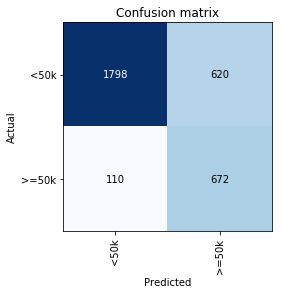

In [38]:
interp.plot_confusion_matrix()

Accuracy got much worse! Down to 77.19%. Clearly we had some important data in that set that we got rid of, and notice that the **opposite** happened now, <50k is doing more than twice as bad as >=50k. Let's try the opposite now.

## Oversampling

Here we will do the exact same, just opposite.

In [0]:
def overSample(df:pd.DataFrame, var:str):
  limit = int(df[var].value_counts().max())
  lst = []
  
  for class_index, group in df.groupby(var):
    if len(group) < limit:
      lst.append(group.sample(limit, replace=True))
    else:
      lst.append(group)
  df = pd.concat(lst)
  return df

In [0]:
over = overSample(train, 'salary')

In [43]:
over['salary'].value_counts()

<50k     17799
>=50k    17799
Name: salary, dtype: int64

Here we tripled the values in order to get up to 17,746 values. Let's analyze them visually and distributively.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1bf8610e48>], dtype=object)

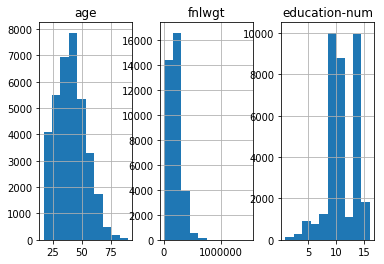

In [142]:
fig, ax = plt.subplots(1,3)

over.hist(column='age', ax=ax[0])
over.hist(column='fnlwgt', ax=ax[1])
over.hist(column='education-num', ax=ax[2])

In [143]:
display_side_by_side(reportInfo(over, cols), reportInfo(train, cols))

,Variable,Mean,Standard Deviation
0,age,38.563025,13.599243
1,fnlwgt,189808.817344,105728.323595
2,education-num,10.085744,2.576080
,Variable,Mean,Standard Deviation
0,age,38.563025,13.599243
1,fnlwgt,189808.817344,105728.323595
2,education-num,10.085744,2.576080


We kept the distrobution the same here as well, and we oversampled. To me, this is only bad because the training could take longer due to almost doubling our dataframe's size

In [145]:
len(train), len(over)

(23443, 35492)

Now let's train

In [0]:
train_val = over.append(valid)
data_train = (TabularList.from_df(train_val, path=path, cat_names=cat_names, 
                                  cont_names=cont_names, procs=procs)
             .split_by_idx(list(range(len(over), len(train_val))))
             .label_from_df(cols=dep_var)
             .databunch())


data_test = (TabularList.from_df(test, path=path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs, 
                                processor=data_train.processor)
            .split_none()
            .label_from_df(cols=dep_var)
            .databunch())



### 10 Times

In [0]:
arr = []
mc = []
for x in range(10):
  learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
  learn.fit(5, 1e-2)
  learn.data.valid_dl = data_test.train_dl
  res = learn.validate()
  arr.append(float(res[1]))
  intp = ClassificationInterpretation.from_learner(learn)
  mc.append(intp.most_confused())

In [46]:
mc

[[('<50k', '>=50k', 602), ('>=50k', '<50k', 116)],
 [('<50k', '>=50k', 768), ('>=50k', '<50k', 81)],
 [('<50k', '>=50k', 639), ('>=50k', '<50k', 106)],
 [('<50k', '>=50k', 588), ('>=50k', '<50k', 119)],
 [('<50k', '>=50k', 657), ('>=50k', '<50k', 106)],
 [('<50k', '>=50k', 730), ('>=50k', '<50k', 99)],
 [('<50k', '>=50k', 565), ('>=50k', '<50k', 127)],
 [('<50k', '>=50k', 525), ('>=50k', '<50k', 147)],
 [('<50k', '>=50k', 666), ('>=50k', '<50k', 99)],
 [('<50k', '>=50k', 665), ('>=50k', '<50k', 109)]]

### Once

In [0]:
learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
learn.fit(5, 1e-2)

In [43]:
learn.data.valid_dl = data_test.train_dl
learn.validate()

[0.4352733, tensor(0.7862)]

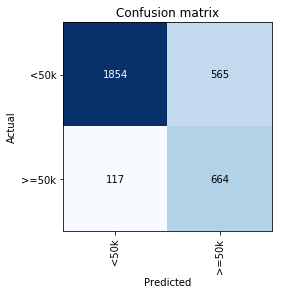

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Once properly fitted, we got around 80%, definetly still not our 82-83% accuracy above, and we still struggle with <50k more, **but** the gap is only ~1,000 samples vs almost 2

## Mixture

This last technique will be a middle-man between the two. We will take the average between the occurances of the two classes, and randomly upsample or downsample accordingly until we have a balanced dataset.

In [47]:
train['salary'].value_counts()

<50k     17799
>=50k     5644
Name: salary, dtype: int64

In [181]:
int((17854+5589)/2)

11721

We should expect each class to have 11721 samples in it

In [0]:
def balanceSample(df, var):
  avg = int(df[var].value_counts().mean())
  lst = []
  
  for class_index, group in df.groupby(var):
    if len(group) < avg:
      lst.append(group.sample(avg, replace = True))
    if len(group) > avg:
      lst.append(group.sample(avg, replace=True))
  df = pd.concat(lst)
  return df

In [0]:
balance = balanceSample(train, 'salary')

In [50]:
balance['salary'].value_counts()

<50k     11721
>=50k    11721
Name: salary, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7f06db320>], dtype=object)

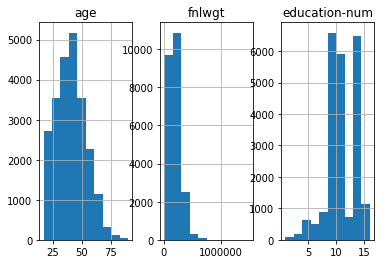

In [49]:
fig, ax = plt.subplots(1,3)

balance.hist(column='age', ax=ax[0])
balance.hist(column='fnlwgt', ax=ax[1])
balance.hist(column='education-num', ax=ax[2])

In [188]:
display_side_by_side(reportInfo(balance, cols), reportInfo(train, cols))

,Variable,Mean,Standard Deviation
0,age,38.553641,13.557654
1,fnlwgt,189071.218402,105184.211227
2,education-num,10.080087,2.565509
,Variable,Mean,Standard Deviation
0,age,38.553641,13.557654
1,fnlwgt,189071.218402,105184.211227
2,education-num,10.080087,2.565509


Everything is still the same, and we have a happy medium in values. Let's train and see how much we differ

In [0]:
train_val = balance.append(valid)
data_train = (TabularList.from_df(train_val, path=path, cat_names=cat_names, 
                                  cont_names=cont_names, procs=procs)
             .split_by_idx(list(range(len(balance), len(train_val))))
             .label_from_df(cols=dep_var)
             .databunch())


data_test = (TabularList.from_df(test, path=path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs, 
                                processor=data_train.processor)
            .split_none()
            .label_from_df(cols=dep_var)
            .databunch())


### 10 Runs

In [0]:
arr = []
mc = []
for x in range(10):
  learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
  learn.fit(5, 1e-2)
  learn.data.valid_dl = data_test.train_dl
  res = learn.validate()
  arr.append(float(res[1]))
  intp = ClassificationInterpretation.from_learner(learn)
  mc.append(intp.most_confused())

In [55]:
mc

[[('<50k', '>=50k', 439), ('>=50k', '<50k', 180)],
 [('<50k', '>=50k', 660), ('>=50k', '<50k', 102)],
 [('<50k', '>=50k', 563), ('>=50k', '<50k', 130)],
 [('<50k', '>=50k', 610), ('>=50k', '<50k', 116)],
 [('<50k', '>=50k', 612), ('>=50k', '<50k', 105)],
 [('<50k', '>=50k', 511), ('>=50k', '<50k', 151)],
 [('<50k', '>=50k', 661), ('>=50k', '<50k', 102)],
 [('<50k', '>=50k', 680), ('>=50k', '<50k', 109)],
 [('<50k', '>=50k', 340), ('>=50k', '<50k', 232)],
 [('<50k', '>=50k', 581), ('>=50k', '<50k', 127)]]

### Single run

In [0]:
learn = tabular_learner(data_train, layers=[200,100], metrics=accuracy)
learn.fit(5, 1e-2)

In [56]:
learn.data.valid_dl = data_test.train_dl
learn.validate()

[0.4130751, tensor(0.7891)]

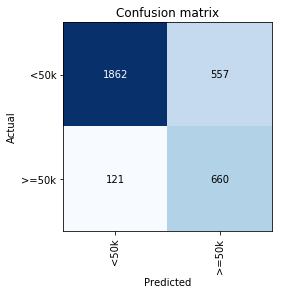

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

A bit more volitile here, but we also only got 78.91% error here... yet again still not the 83% but notice the class losses are almost equivalent now! Let's analyze that a bit further in excel.